# 作業：自行調整完整版 Bert 預訓練模型
***

## [作業目標]
- 調整 Step4.3 類神經網路結構，觀察對結果影響
- 調整 Step4.2 Batch Size 以及 Step4.4 的 Optimizer & Learning Rate 觀察帶來的影響

## [作業重點]
- 程式最後會輸出 Kaggle 提交檔，可以藉由提交分數驗證結果
- 記得以檔名或其他形式保留調整的紀錄，以免忘記最佳輸出的調整方式

## 載入套件、資料切割和前處理

In [1]:
# 載入相關套件
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler
)
from transformers import (
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
    set_seed
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 將訓練資料切分成訓練集/驗證集
df = pd.read_csv('data/train.csv')
X = df.text.values
y = df.target.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2021)

In [3]:
# 載入測試資料
test_df = pd.read_csv('data/test.csv')
test_df = test_df[['id', 'text']]
test_df.sample(5)

,id,text
2892,9573,The goddess is said to be married to either Pe...
3155,10474,WILD FIRES! http://t.co/EgrMdkXpOi
1600,5402,Truck driver died in Turnpike fire most lanes ...
2097,7035,Oh Shelly your waffle wasn't 'a little blonde....
2135,7145,@AlexxPage cried at the mudslide cake ??


In [4]:
# 依照現有環境判定是否使用 GPU
if torch.cuda.is_available():       
    device = torch.device('cuda')
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")

else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
Device name: Tesla K80


In [5]:
# 簡化版前處理
def text_preprocessing(text):
    # 移除推特姓名標籤('@name')
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    # 將'&amp;'替換成'&'
    text = re.sub(r'&amp;', '&', text)
    # 移除文末的空白字元
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
# 印出第一組推文在前處理前/後的內容
print(f"Original: {X[0]}")
print(f"Processed: {text_preprocessing(X[0])}")

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Processed: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


## Step 4.1：載入 Bert 套件與 tokenizer，且將本文編碼

In [7]:
# 載入 Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# 設定 Bert 的前處理函數
def preprocessing_for_bert(data):
    # 初始化要傳回的資料
    input_ids = []
    attention_masks = []
    # 把所有文句用 tokenizer 編碼
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # 套用簡化版前處理函數
            add_special_tokens=True,  # 加上`[CLS]`與`[SEP]`
            max_length=MAX_LEN,  # 需要填充的最大長度
            pad_to_max_length=True,  # 是否要填充到最大長度
            return_attention_mask=True  # 是否傳回 attention mask
        )
        # 更新要傳回的資料
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # 將傳回資料轉為 tensor
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [8]:
# 將訓練資料與測試資料的"推文"合併
all_tweets = np.concatenate([df.text.values, test_df.text.values])

# 將推文使用 tokenizer 加以編碼
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# 找出最大的推文長度 (訓練資料＋預測目標資料)
max_len = max([len(sent) for sent in encoded_tweets])
print(f"Max length: {max_len}")

Max length: 84


In [9]:
# 將上面的 Max length 數值填入
MAX_LEN = 84

# 顯示第一筆資料的推文與經過 Bert 的前處理函數(preprocessing_for_bert)的編碼結果(確認函數正確)
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print(f"Original: {X[0]}")
print(f"Token IDs: {token_ids}")

# 使用 preprocessing_for_bert 將訓練/驗證集的推文進行編碼
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs: [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


## Step 4.2：Fine Tune 前的準備 - 設定 Batch Size

In [10]:
# 將訓練與驗證目標值轉為 torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# 要微調(fine-tuning) BERT 時, 原作者建議的 batch size 為 16 或 32
batch_size = 32

# 設定訓練與驗證集的 DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Step 4.3：設定 Bert 連接目標值的 Layer 結構

In [11]:
%%time

# 自定義 Bert 分類器函數
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # 指定 BERT 輸入維度大小(D_in), 分類器的隱藏層大小(H), 以及分類目標值的類別數量(D_out)
        D_in, H, D_out = 768, 50, 2
        # 載入 Bert 預訓練權重作為初始值
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # 初始化自定義分類器的類神經網路
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )
        # 凍結 Bert 部分的權重
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # 將資料輸入 BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)        
        # 將輸出結果存在 last_hidden_state_cls 中
        last_hidden_state_cls = outputs[0][:, 0, :]
        # 將輸出結果輸入自定義分類器
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 0 ns, sys: 35 µs, total: 35 µs
Wall time: 38.9 µs


# Step 4.4：Optimizer & Learning Rate

In [12]:
def initialize_model(epochs=4):
    # 初始化 Bert 分類器
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)
    # 設定 optimizer
    optimizer = AdamW(
        bert_classifier.parameters(),
        lr=2e-5,  # 預設的學習速率
        eps=1e-8  # 預設的 epsilon 值
    )
    # 計算總共的訓練步數
    total_steps = len(train_dataloader) * epochs
    # 設定學習率排程
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # 預設值
                                                num_training_steps=total_steps)

    return bert_classifier, optimizer, scheduler

In [13]:
# 設定損失函數
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    # 開始訓練迴圈
    print('Start training...\n')
    for epoch_i in range(epochs):
        # 印出變數表格標題
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | "
              f"{'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print('-' * 70)
        # 計算每個 epoch 的執行時間
        t0_epoch, t0_batch = time.time(), time.time()
        # 每個 epoch 開始時重置追蹤的變數
        total_loss, batch_loss, batch_counts = 0, 0, 0
        # 將模型切換到訓練模式
        model.train()
        # 訓練資料的每個 batch
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            # 將模型之前計算的梯度歸零
            model.zero_grad()
            # 執行前向傳遞. 這會傳回 logits 值
            logits = model(b_input_ids, b_attn_mask)
            # 計算並累加損失值
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            # 執行後向傳遞以計算梯度
            loss.backward()
            # 將梯度侷限在正負 1 範圍內, 防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # 更新參數與學習率
            optimizer.step()
            scheduler.step()
            # 每 20 個 batches 印出損失值與執行時間
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # 計算 20 batches 的執行時間
                time_elapsed = time.time() - t0_batch
                # 印出訓練結果
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} "
                      f"| {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                # 重置 batch 追蹤變數
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        # 計算全部訓練資料的平均損失值
        avg_train_loss = total_loss / len(train_dataloader)

        print('-' * 70)
        if evaluation == True:
            # 每個 epoch 訓練完畢後, 在驗證集上檢驗模型的表現
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            time_elapsed = time.time() - t0_epoch            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | "
                  f"{val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print('-' * 70)
        print('\n')    
    print('Training complete!')

def evaluate(model, val_dataloader):
    # 將模型切換到測試模式：暫停使用 dropout
    model.eval()
    # 追蹤結果變數
    val_accuracy = []
    val_loss = []
    # 驗證資料的每個 batch 
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # 計算 logits 值
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        # 計算損失值
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        # 取得預測值
        preds = torch.argmax(logits, dim=1).flatten()
        # 計算 accuracy 數值
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    # 計算全部驗證資料的平均損失值與平均 accuracy
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## 執行訓練：依機器的計算能力調整 epoch 大小

In [14]:
set_seed(42)  # 設定隨機種子
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.642533   |     -      |     -     |   18.16  
   1    |   40    |   0.551185   |     -      |     -     |   17.22  
   1    |   60    |   0.495677   |     -      |     -     |   17.31  
   1    |   80    |   0.434480   |     -      |     -     |   17.37  
   1    |   100   |   0.435570   |     -      |     -     |   17.44  
   1    |   120   |   0.409658   |     -      |     -     |   17.48  
   1    |   140   |   0.442118   |     -      |     -     |   17.51  
   1    |   160   |   0.399895   |     -      |     -     |   17.46  
   1    |   180   |   0.417886   |     -      |     -     |   17.47  
   1    |   200   |   0.414745   |     -      |     -     |   17.48  
   1    |   214   |   0.392267   |     -      |     -     |   11.59  
---------------------------------------------------------------------

## 繪製 ROC_AUC：觀察預測效果

In [15]:
def bert_predict(model, test_dataloader):
    # 將模型切換到測試模式：暫停使用 dropout
    model.eval()
    all_logits = []

    # 測試資料的每個 batch
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        # 計算機率
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    # 將每個 batch 的 logits 合併
    all_logits = torch.cat(all_logits, dim=0)
    # 使用 softmax 計算機率
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [16]:
def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')    
    # 取得測試集的 accuracy 值
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')    
    # 繪製 ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label=f"AUC = {roc_auc:.2f}")
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8960
Accuracy: 84.12%


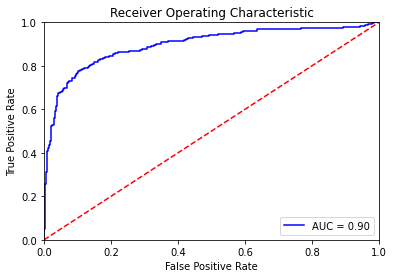

In [17]:
# 在測試集上計算預測機率
probs = bert_predict(bert_classifier, val_dataloader)
# 評估 Bert 分類器
evaluate_roc(probs, y_val)

## 重新以完整資料訓練模型，並對預測資料進行輸出

In [18]:
# 合併訓練集與驗證集
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# 在完整的訓練資料上重新訓練 Bert 分類器
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, full_train_dataloader, epochs=3)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.652094   |     -      |     -     |   18.38  
   1    |   40    |   0.559867   |     -      |     -     |   17.46  
   1    |   60    |   0.467710   |     -      |     -     |   17.44  
   1    |   80    |   0.452324   |     -      |     -     |   17.45  
   1    |   100   |   0.405436   |     -      |     -     |   17.44  
   1    |   120   |   0.449223   |     -      |     -     |   17.46  
   1    |   140   |   0.422677   |     -      |     -     |   17.48  
   1    |   160   |   0.433562   |     -      |     -     |   17.47  
   1    |   180   |   0.425404   |     -      |     -     |   17.48  
   1    |   200   |   0.363934   |     -      |     -     |   17.49  
   1    |   220   |   0.387681   |     -      |     -     |   17.50  
   1    |   237   |   0.408685   |     -      |     -     |   14.82  


In [19]:
test_df.sample(5)

,id,text
2406,8051,Refugees as citizens - The Hindu http://t.co/G...
134,425,@5SOStag honestly he could say an apocalypse i...
411,1330,If you bored as shit don't nobody fuck wit you...
203,663,@RealTwanBrown Yesterday I Had A Heat Attack ?...
889,2930,The Devil Wears Prada is still one of my favou...


In [20]:
# 在測試集推文上執行 `preprocessing_for_bert` 函數
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_df['text'])
# 宣告測試集的 DataLoader
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [21]:
# 在測試資料上計算最終預測機率
probs = bert_predict(bert_classifier, test_dataloader)
# 將機率值轉為預測(超過門檻的預測為 1, 否則為 0)
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)
# 顯示被判定為正向
print(f"Number of tweets predicted non-negative: {preds.sum()}",)

Number of tweets predicted non-negative: 988


In [22]:
# 生成提交擋
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = preds
submission.to_csv('submission_FineTuneBert.csv', index=False)